# libs

In [1]:
!pip install keras_cv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 63.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
#Libraries
import PIL # image processing and visualization
import tensorflow as tf # the AI library
import tensorflow_hub as hub
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
import keras_cv
import cv2
from keras import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
from keras.applications.vgg16 import VGG16
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, mean_absolute_error

warnings.filterwarnings("ignore")
tfk = tf.keras
tfkl = tf.keras.layers

Using TensorFlow backend


# set seed

In [4]:
# set a random seed so that results from several trials are comparable
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Data preprocessing

In [5]:
# definitions

label_folder=r'/gdrive/My Drive/BioSig project/Rawdata_values.csv'
img_folder= r'/gdrive/My Drive/BioSig project/rawdata/'
img_height = 320
img_width = 204
img_channels = 3
n_outputs = 3

In [6]:
# extract images from image folder and set range from 0-1 instead of 0-255
def create_dataset(img_folder):

    img_data_array=[]
    class_name=[]

    for file in os.listdir(img_folder):
        image_path= os.path.join(img_folder,  file)
        image= cv2.imread( image_path, cv2.COLOR_BGR2RGB)
        image=cv2.resize(image, (img_width, img_height),interpolation = cv2.INTER_AREA)
        image=np.array(image)
        image = image.astype('float32')
        image /= 255
        img_data_array.append(image)
    return img_data_array

# Extract images
img_data = create_dataset(img_folder)

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv(label_folder, sep = ';', header = None)


# Split data into train, validation and test set
train_label = np.array(df)[1:18,1:].astype(np.float32) # left 5 samples as test set 80-20-20 split
val_label = np.array(df)[18:23,1:].astype(np.float32) # left 5 samples as test set 80-20-20 split
test_label = np.array(df)[23:,1:].astype(np.float32)

train_data = img_data[:17] # left 5 samples as test set 80-20-20 split
val_data = img_data[17:22] # left 5 samples as test set 80-20-20 split
test_data = img_data[22:]

### plot images

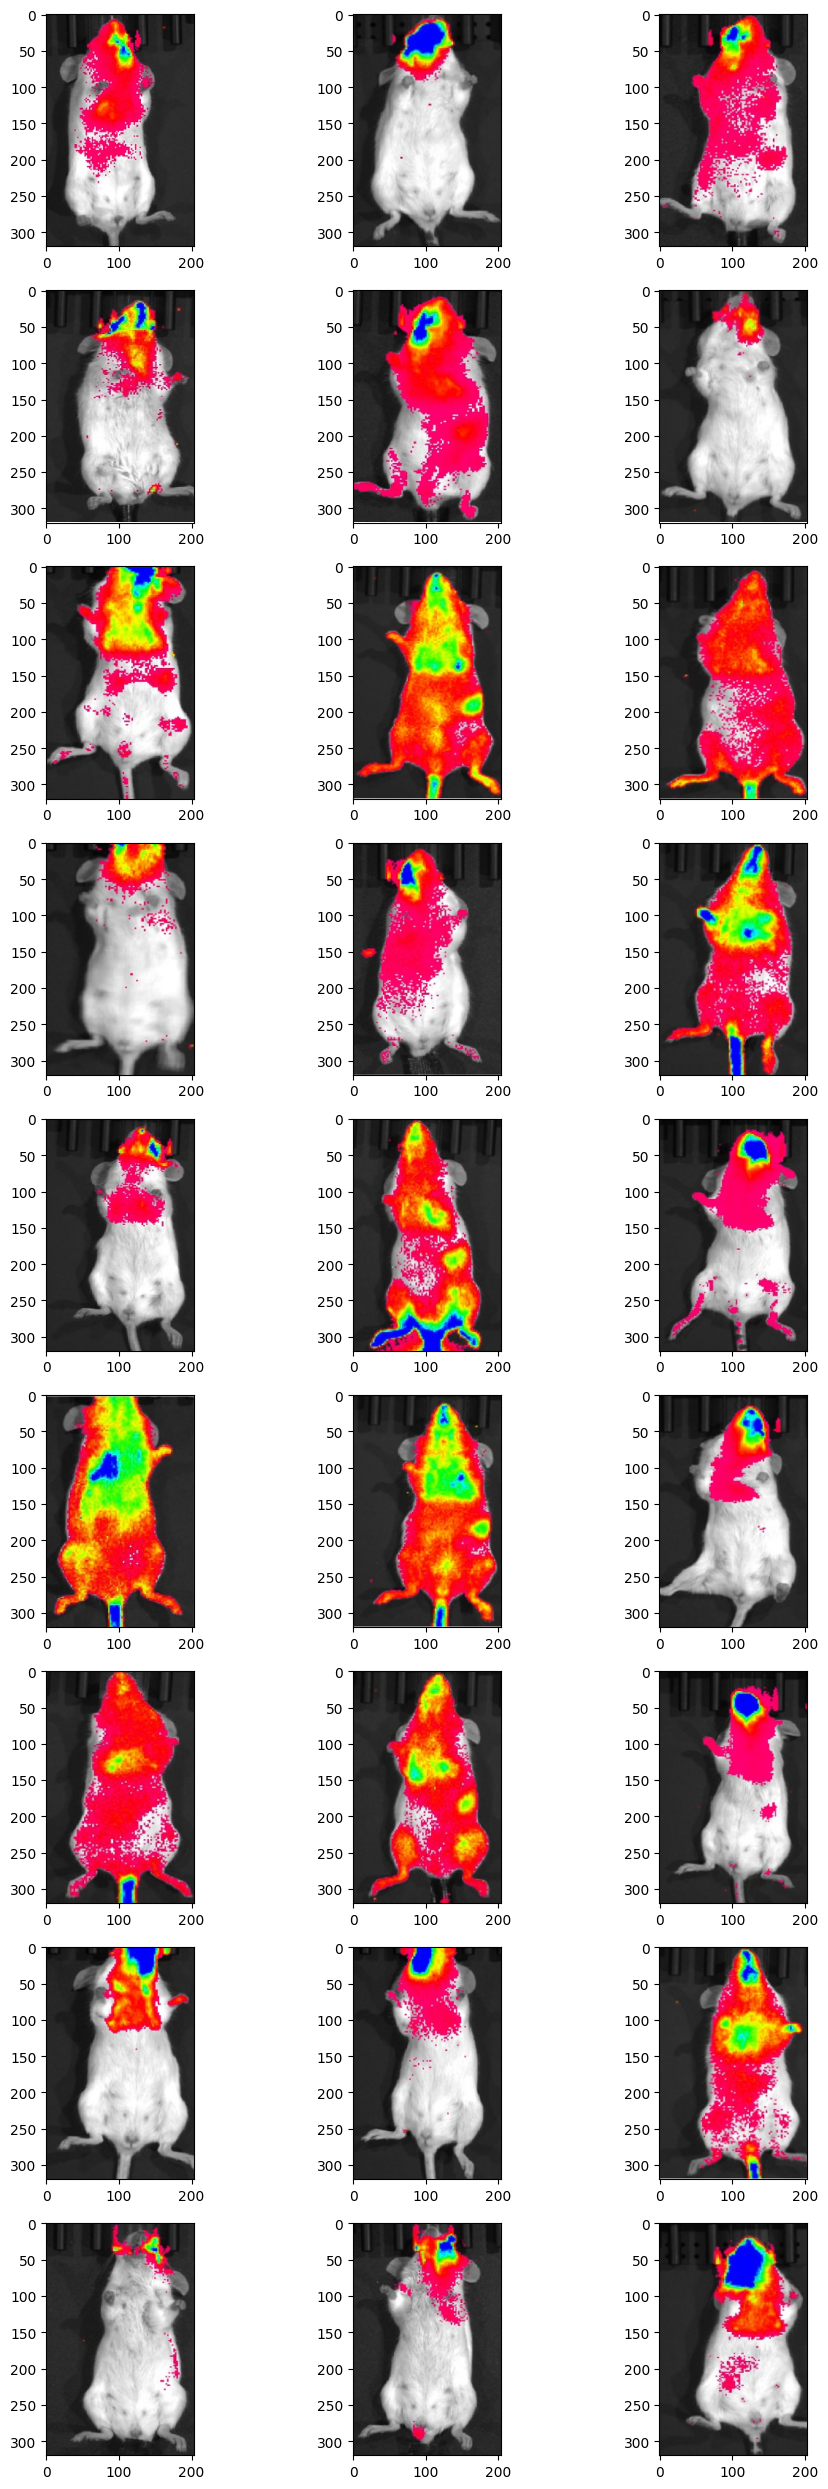

In [7]:
fig, axs = plt.subplots(9,3, figsize=(10,25))
for i in range(len(img_data)):
  axs.flatten()[i].imshow(img_data[i])
plt.tight_layout()
plt.show()

### convert to tensorflow datasets

In [8]:
# make the output data closer to 1

train_label_norm = train_label/100000
val_label_norm = val_label/100000
test_label_norm = test_label/100000

# print to see the difference
print(val_label)
print(val_label_norm)

[[1127000.  544400.  199800.]
 [4057000.  623700.  231500.]
 [1864000. 1414000.  399500.]
 [2548000. 2123000.  678300.]
 [2223000. 1842000.  501300.]]
[[11.27   5.444  1.998]
 [40.57   6.237  2.315]
 [18.64  14.14   3.995]
 [25.48  21.23   6.783]
 [22.23  18.42   5.013]]


In [9]:
# turn np array into tensorflow tensors
x_train = tf.convert_to_tensor(train_data, tf.float32)
x_val = tf.convert_to_tensor(val_data,     tf.float32)
x_test = tf.convert_to_tensor(test_data,     tf.float32)

y_train = tf.convert_to_tensor(train_label_norm, tf.float32)
y_val = tf.convert_to_tensor(val_label_norm,     tf.float32)
y_test = tf.convert_to_tensor(test_label_norm,     tf.float32)

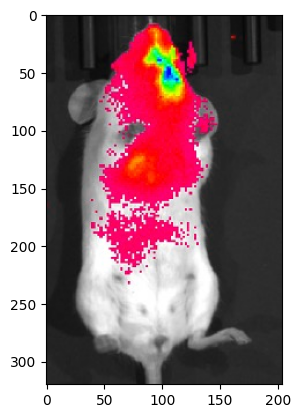

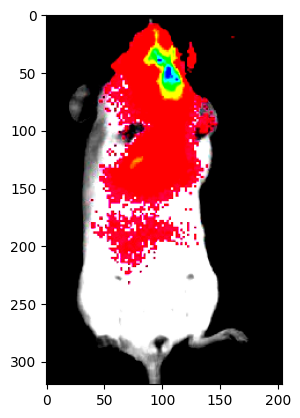

In [10]:
# standardize each image

x_train_st = tf.image.per_image_standardization(x_train)
x_val_st = tf.image.per_image_standardization(x_val)
x_test_st = tf.image.per_image_standardization(x_test)

# plot first image again before and after standardization
plt.figure()
plt.imshow(x_train[0])

plt.figure()
plt.imshow(x_train_st[0])

In [11]:
# turn tf tensors into tf datasets
x_train_tf = tf.expand_dims(x_train_st, axis=0)
x_val_tf = tf.expand_dims(x_val_st, axis=0)
y_train_tf = tf.expand_dims(y_train, axis=0)
y_val_tf = tf.expand_dims(y_val, axis=0)

train_ds = tf.data.Dataset.from_tensor_slices((x_train_tf, y_train_tf))
val_ds = tf.data.Dataset.from_tensor_slices((x_val_tf, y_val_tf))

# Data augmentation

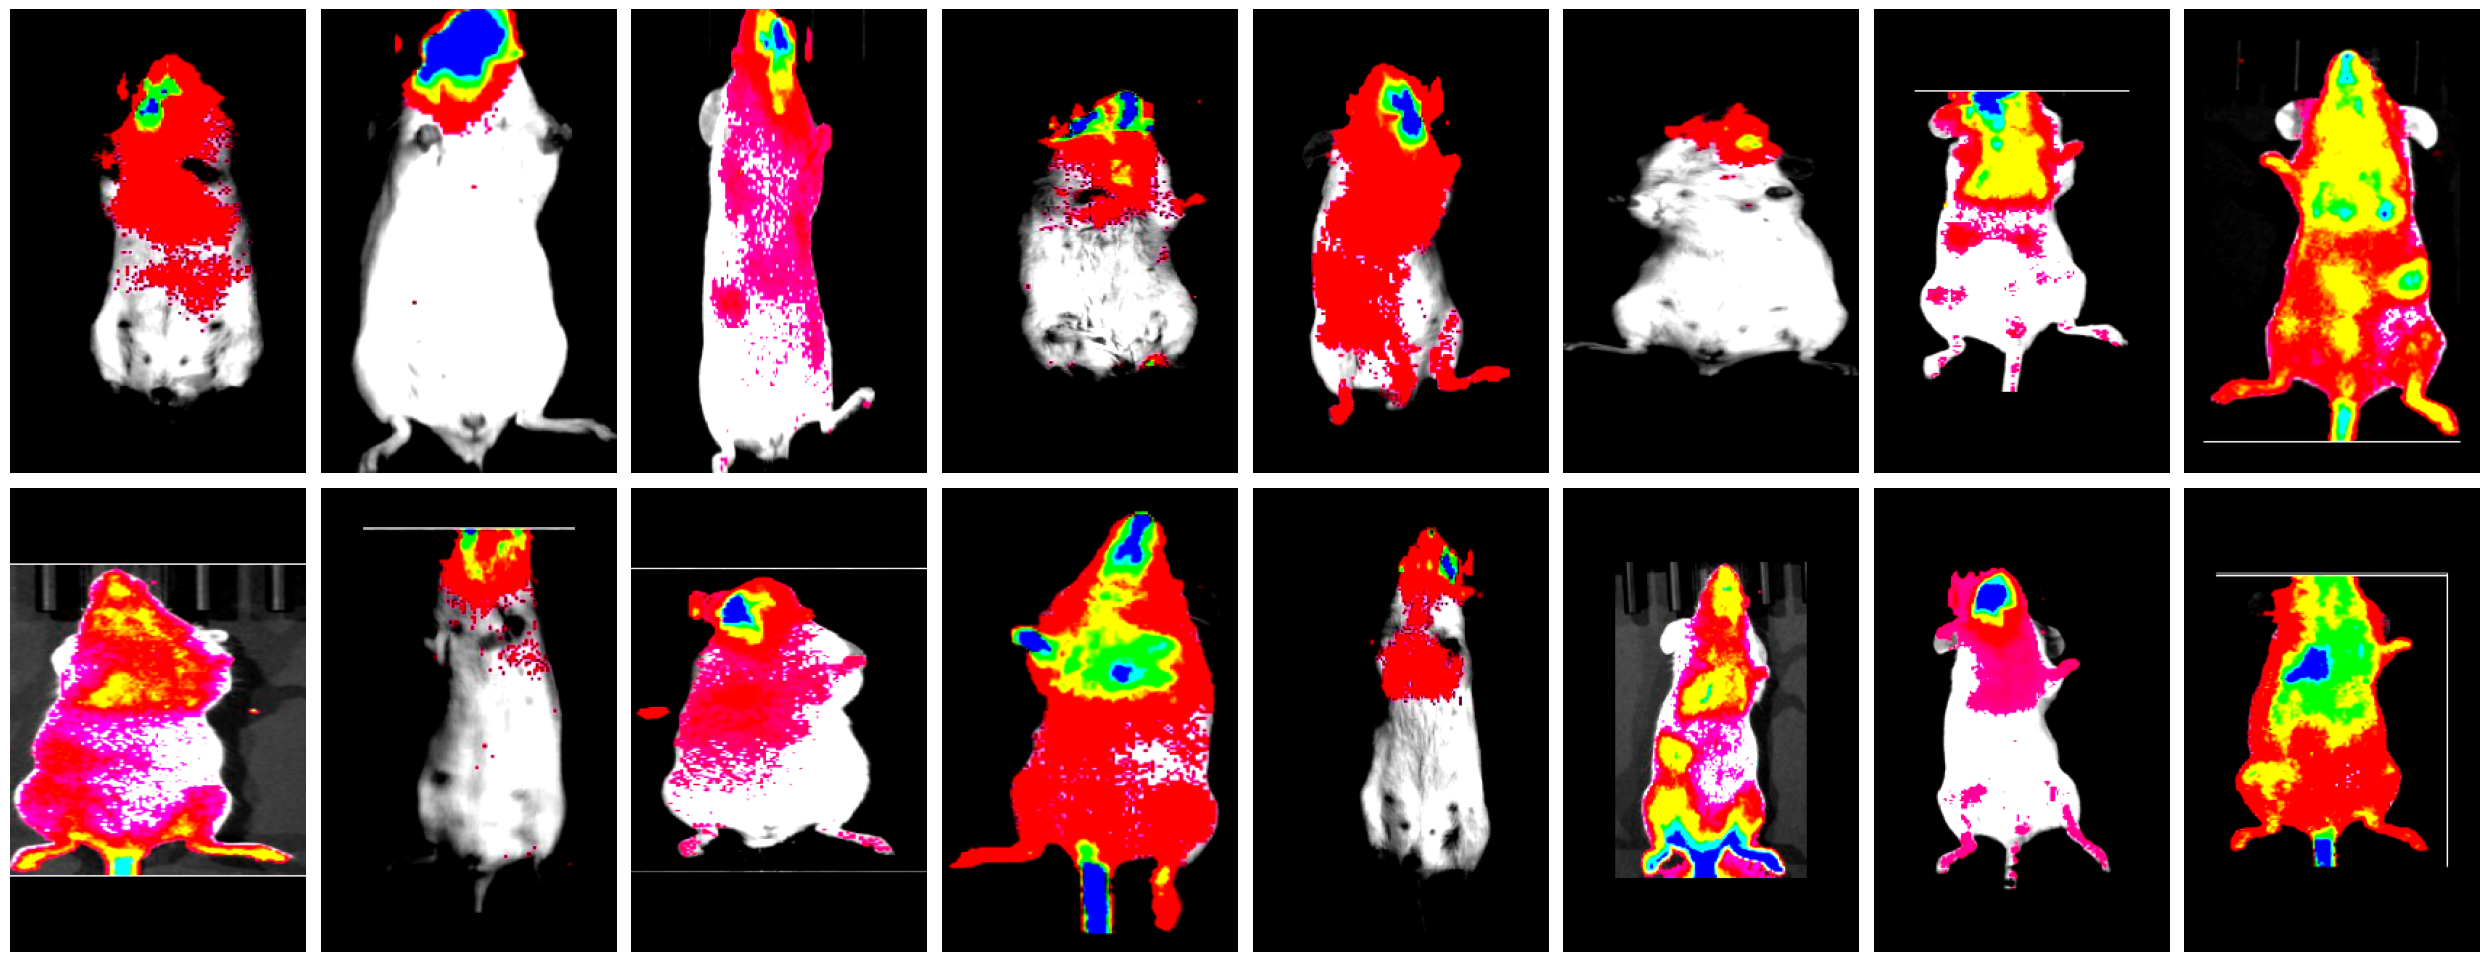

In [12]:
# Visualize the different augmentations

data_augmentation = tfk.Sequential([
  tfkl.RandomBrightness(factor=0.003),
  #tfkl.RandomContrast(factor=0.5),
  tfkl.RandomZoom(height_factor=(-0.1, 0.7), width_factor=(-0.2,0.7), fill_mode='constant', fill_value=0.0),
  #tfkl.Resizing(height=224,width=224, interpolation='nearest'),
  tfkl.RandomFlip("horizontal"),
  #tfkl.RandomRotation(factor=0.1, fill_mode='constant', fill_value=0.0), # 0.2 means image will be randomly rotated
  #tfkl.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.2,0.2), fill_mode='constant', fill_value=0.0),
  ])

# do random augmentation
aug_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

# plot
plt.figure(figsize=(25,10))
for images, lables in aug_ds:
  for i in range(16):
    ax = plt.subplot(2, 8, i + 1)
    plt.imshow(images[i].numpy())
    plt.axis('off')
plt.tight_layout()

In [ ]:
'''# resize the validataion set to match training set
resize = tfk.Sequential([
  tfkl.Resizing(height=224,width=224, interpolation='nearest'),
])

# apply resizing
val_ds = val_ds_0.map(
  lambda x, y: (resize(x, training=True), y))

# plot
plt.figure(figsize=(25,10))
for images, lables in val_ds:
  for i in range(5):
    ax = plt.subplot(1, 5, i + 1)
    plt.imshow(images[i].numpy())
    plt.axis('off')
plt.tight_layout()'''

"# resize the validataion set to match training set\nresize = tfk.Sequential([\n  tfkl.Resizing(height=224,width=224, interpolation='nearest'),\n])\n\n# apply resizing\nval_ds = val_ds_0.map(\n  lambda x, y: (resize(x, training=True), y))\n\n# plot\nplt.figure(figsize=(25,10))\nfor images, lables in val_ds:\n  for i in range(5):\n    ax = plt.subplot(1, 5, i + 1)\n    plt.imshow(images[i].numpy())\n    plt.axis('off')\nplt.tight_layout()"

# Model without transfer learning

### build model

In [ ]:

# Define the model
model = tf.keras.Sequential([
  # data augmentation
  tfkl.InputLayer((img_height, img_width, img_channels)),
  tfkl.RandomBrightness(factor=0.003, input_shape=(img_height, img_width, img_channels)),
  tfkl.RandomZoom(height_factor=(-0.1, 0.7), width_factor=(-0.2,0.7), fill_mode='constant', fill_value=0.0),
  tfkl.RandomFlip("horizontal"),
  #tfkl.RandomRotation(factor=0.1, fill_mode='constant', fill_value=0.0),
  #tfkl.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.2,0.2), fill_mode='constant', fill_value=0.0),

  # Convolutional layer with 32 filters, 3x3 kernel size, and ReLU activation
  tfkl.Conv2D(32, (3, 3), activation='relu'),
  # Max pooling layer with 2x2 pool size
  tfkl.MaxPool2D((2, 2)),
  # Convolutional layer with 64 filters, 3x3 kernel size, and ReLU activation
  tfkl.Conv2D(64, (3, 3), activation='relu'),
  # Max pooling layer with 2x2 pool size
  tfkl.MaxPool2D((2, 2)),
  # Convolutional layer with 128 filters, 3x3 kernel size, and ReLU activation
  tfkl.Conv2D(128, (3, 3), activation='relu'),
  # Max pooling layer with 2x2 pool size
  tfkl.MaxPool2D((2, 2)),
  # Flatten the output of the last convolutional layer
  tfkl.Flatten(),
  # Fully connected layer with 256 units and ReLU activation
  tfkl.Dense(256, activation='relu'),
  # Dropout layer with 0.5 dropout rate
  tfkl.Dropout(0.5),
  # Output layer with 3 units and linear activation
  tfkl.Dense(3, activation='linear')
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Print the model summary
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_brightness_1 (Rando  (None, 320, 204, 3)       0         
 mBrightness)                                                    
                                                                 
 random_zoom_1 (RandomZoom)  (None, 320, 204, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 320, 204, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 318, 202, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 159, 101, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 157, 99, 64)      

In [ ]:
# do early stopping to prevent overfitting

early_stop = EarlyStopping(monitor='val_loss',
                           patience=50,
                           restore_best_weights=True,
                           mode='min')

### run model

In [ ]:
%%time

history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stop]).history

Epoch 1/100
1/1 [==============================] - 10s 10s/step - loss: 3214.5176 - mean_absolute_error: 29.9104 - val_loss: 422.4068 - val_mean_absolute_error: 16.3937
Epoch 2/100
1/1 [==============================] - 3s 3s/step - loss: 2188.7195 - mean_absolute_error: 21.2168 - val_loss: 5060.2593 - val_mean_absolute_error: 58.0888
Epoch 3/100
1/1 [==============================] - 3s 3s/step - loss: 1676.8579 - mean_absolute_error: 23.9445 - val_loss: 6418.4629 - val_mean_absolute_error: 60.4778
Epoch 4/100
1/1 [==============================] - 3s 3s/step - loss: 3672.1191 - mean_absolute_error: 40.8519 - val_loss: 1244.6814 - val_mean_absolute_error: 24.2752
Epoch 5/100
1/1 [==============================] - 4s 4s/step - loss: 1741.7991 - mean_absolute_error: 21.5246 - val_loss: 193.9784 - val_mean_absolute_error: 9.8387
Epoch 6/100
1/1 [==============================] - 4s 4s/step - loss: 2284.3511 - mean_absolute_error: 22.2090 - val_loss: 54.3269 - val_mean_absolute_error: 5.5

### model results

In [ ]:
# print model predictions compared to correct lables
#model.predict(x_train), model.predict(x_val), model.predict(x_test_st), y_train, y_val, y_test
model.predict(x_test_st), y_test

1/1 [==============================] - 1s 701ms/step


(array([[28.215227 ,  7.561388 ,  3.8493583],
        [28.333406 ,  9.459996 ,  3.5634432],
        [23.247    ,  8.231386 ,  2.225807 ],
        [29.740088 ,  7.514889 ,  4.440947 ],
        [28.49432  ,  8.593171 ,  3.566179 ]], dtype=float32),
 <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
 array([[25.03 , 20.05 ,  6.308],
        [15.85 ,  7.269,  3.223],
        [19.91 ,  4.986,  1.576],
        [23.85 ,  9.776,  2.595],
        [20.75 , 10.2  ,  2.225]], dtype=float32)>)

In [ ]:
# Test set MAE
mae = mean_absolute_error(y_test, model.predict(x_test_st))
print(f"Mean absolute error: {mae:.2f}")

1/1 [==============================] - 1s 868ms/step
Mean absolute error: 4.07


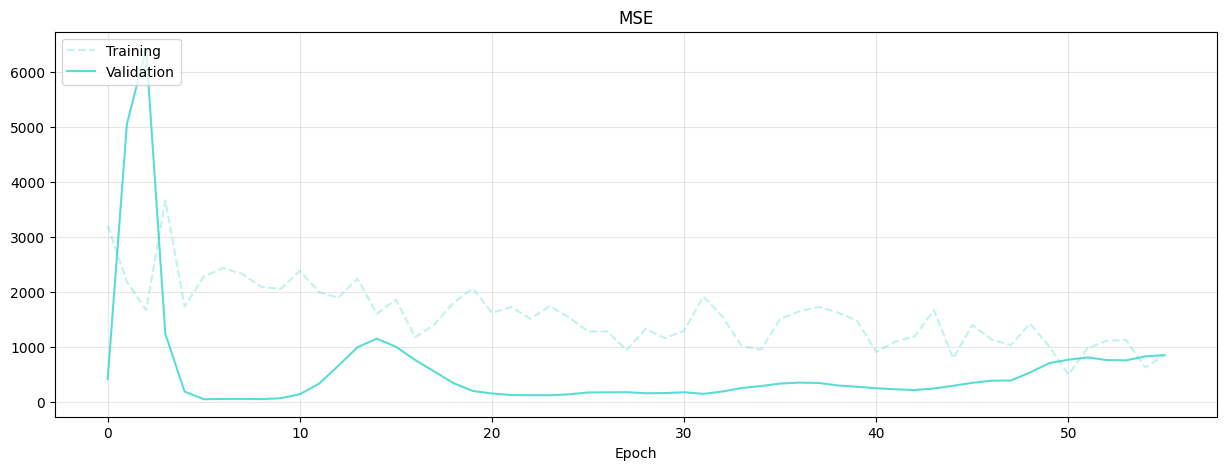

In [ ]:
#plots of the training and validation loss evolving for each epoch
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.3, color='#30D5C8', linestyle='--')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#30D5C8')
plt.legend(loc='upper left')
plt.xlabel('Epoch')
plt.title('MSE')
plt.grid(alpha=.3)

plt.show()

# Transfer learning Model

### build model

In [ ]:
# Load the MobileNet V2 model
model_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
mobile_model = hub.KerasLayer(model_url, input_shape=(224, 224, 3), trainable=False)

# Fine tune only the last few layers of the MobileNet model
mobile = tf.keras.applications.MobileNet(include_top=False, weights='imagenet', input_shape=(224,224,3))
mobile.trainable = False

# Define an input layer
input_layer = tf.keras.layers.Input(shape=(img_height, img_width, img_channels))

# Do augmentation and re-sizing
x = tfkl.RandomBrightness(factor=0.003)(input_layer) #0.003
x = tfkl.RandomZoom(height_factor=(-0.1, 0.7), width_factor=(-0.2,0.7), fill_mode='constant', fill_value=0.0)(x)
x = tfkl.Resizing(height=224,width=224, interpolation='nearest')(x)
x = tfkl.RandomFlip("horizontal")(x)
x = tfkl.RandomRotation(factor=0.1, fill_mode='constant', fill_value=0.0)(x)
x = tfkl.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.2,0.2), fill_mode='constant', fill_value=0.0)(x)

# Pass the resized input to the MobileNet model
x = mobile(x)

# Add the rest of the layers
x = tfkl.GlobalAveragePooling2D()(x)
x = tfkl.Dense(128, activation='relu')(x) #128
x = tfkl.Dropout(0.5)(x)
predictions = tfkl.Dense(3, activation='linear')(x)

# Create the model
mobile_model = tf.keras.Model(inputs=input_layer, outputs=predictions)

# Compile the model
mobile_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Model summary
mobile_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 320, 204, 3)]     0         
                                                                 
 random_brightness_2 (Rando  (None, 320, 204, 3)       0         
 mBrightness)                                                    
                                                                 
 random_zoom_2 (RandomZoom)  (None, 320, 204, 3)       0         
                                                                 
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 224, 224, 3)       0         
 otation)                                                    

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=500,
                           restore_best_weights=True,
                           mode='min')

### run model

In [ ]:
%%time

mobile_history = mobile_model.fit(train_ds, validation_data=val_ds, epochs=500, callbacks=[early_stop]).history

Epoch 1/500
1/1 [==============================] - 6s 6s/step - loss: 3216.1108 - mean_absolute_error: 29.5988 - val_loss: 247.3861 - val_mean_absolute_error: 12.4429
Epoch 2/500
1/1 [==============================] - 1s 950ms/step - loss: 3061.2036 - mean_absolute_error: 28.6150 - val_loss: 197.9506 - val_mean_absolute_error: 10.9508
Epoch 3/500
1/1 [==============================] - 1s 1s/step - loss: 2971.7014 - mean_absolute_error: 27.4422 - val_loss: 158.7487 - val_mean_absolute_error: 9.3461
Epoch 4/500
1/1 [==============================] - 1s 921ms/step - loss: 2813.1411 - mean_absolute_error: 25.9388 - val_loss: 126.9191 - val_mean_absolute_error: 8.1255
Epoch 5/500
1/1 [==============================] - 1s 941ms/step - loss: 2666.0645 - mean_absolute_error: 24.4787 - val_loss: 103.8693 - val_mean_absolute_error: 7.1549
Epoch 6/500
1/1 [==============================] - 1s 928ms/step - loss: 2526.2234 - mean_absolute_error: 24.2146 - val_loss: 88.7670 - val_mean_absolute_error

### results

In [ ]:
# print model predictions compared to correct lables
#mobile_model.predict(x_train), mobile_model.predict(x_val), mobile_model.predict(x_test_st), y_train, y_val, y_test
mobile_model.predict(x_test_st), y_test

1/1 [==============================] - 0s 199ms/step


(array([[90.84818  , 20.617403 ,  6.7219377],
        [11.583413 , 12.753373 ,  2.5430415],
        [34.980232 , 15.159995 ,  1.6200159],
        [40.14838  , 18.813307 ,  3.1865435],
        [50.6304   , 22.411797 ,  6.446569 ]], dtype=float32),
 <tf.Tensor: shape=(5, 3), dtype=float32, numpy=
 array([[25.03 , 20.05 ,  6.308],
        [15.85 ,  7.269,  3.223],
        [19.91 ,  4.986,  1.576],
        [23.85 ,  9.776,  2.595],
        [20.75 , 10.2  ,  2.225]], dtype=float32)>)

In [ ]:
# Test set MAE
mae = mean_absolute_error(y_test, mobile_model.predict(x_test_st))
print(f"Mean absolute error: {mae}")

1/1 [==============================] - 1s 1s/step
Mean absolute error: 11.65064525604248


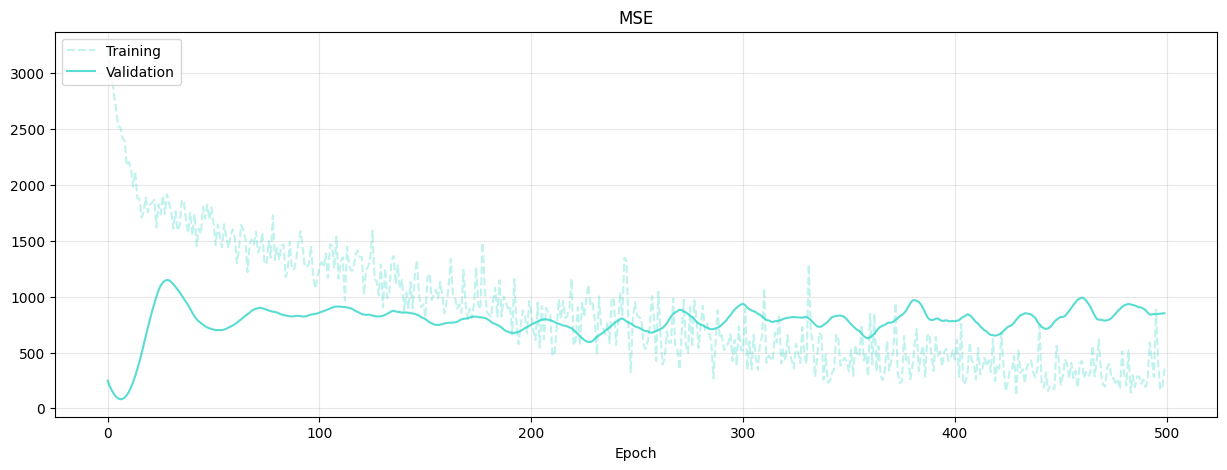

In [ ]:
#plots of the loss and accuracy evolving for each epoch
plt.figure(figsize=(15,5))
plt.plot(mobile_history['loss'], label='Training', alpha=.3, color='#30D5C8', linestyle='--')
plt.plot(mobile_history['val_loss'], label='Validation', alpha=.8, color='#30D5C8')
plt.legend(loc='upper left')
plt.xlabel('Epoch')
plt.title('MSE')
plt.grid(alpha=.3)

plt.show()